# Set up Notebook

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Applied Deep Learning/brand-recognition/data/'

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from PIL import ImageFile, Image
from cv2 import resize

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.applications import VGG16, Xception, ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Exploration

In [ ]:
vehicles_brands = os.listdir(path+'train')

In [ ]:
for k in vehicles_brands:
    print(k.title())

Mercedes-Benz
Kia
Ford
Volkswagen
Bmw
Nissan
Mazda
Renault
Toyota
Chevrolet


In [ ]:
path_models = path + 'models/'
path_train = path + 'train/'
path_test = path + 'test/'
path_val = path + 'val/'

In [ ]:
for vehicles_brand in vehicles_brands:
    path_vehic = path_train + vehicles_brand
    nb_imgs = len(os.listdir(path_vehic))
    print(f'There are {nb_imgs} images of {vehicles_brand.split("/")[0]} in the train set.')


There are 779 images of mercedes-benz in the train set.
There are 777 images of kia in the train set.
There are 800 images of ford in the train set.
There are 782 images of volkswagen in the train set.
There are 782 images of bmw in the train set.
There are 761 images of nissan in the train set.
There are 790 images of mazda in the train set.
There are 803 images of renault in the train set.
There are 764 images of toyota in the train set.
There are 769 images of chevrolet in the train set.


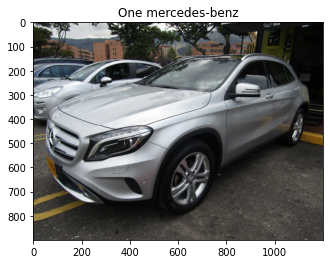

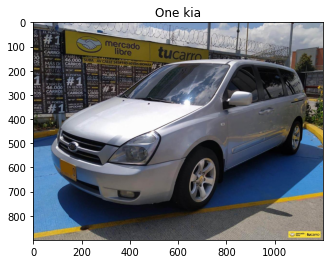

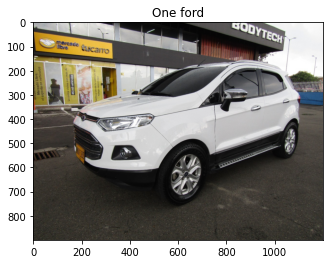

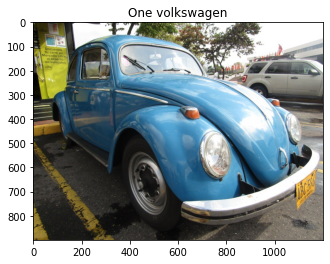

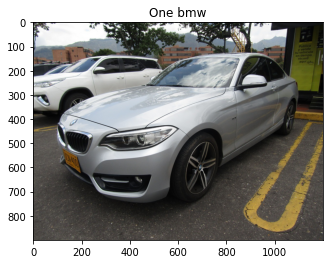

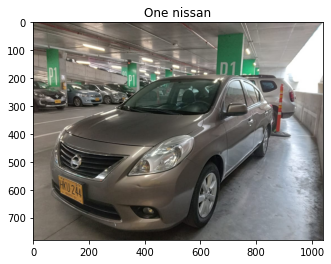

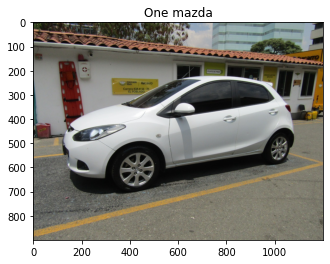

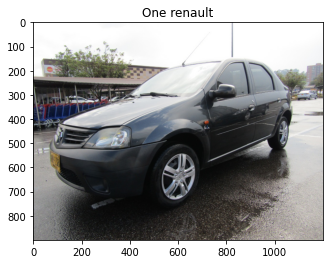

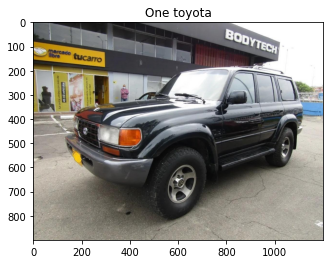

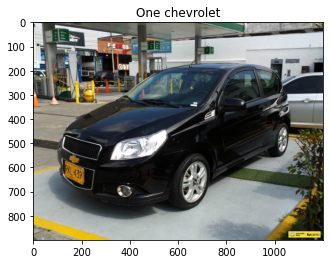

In [ ]:
for vehicle_brand in vehicles_brands:
  path_img = path_train + f'{vehicle_brand}/{vehicle_brand}0.jpg'
  img_vehic = Image.open(path_img)
  img_vehic = np.array(img_vehic)
  plt.imshow(img_vehic)
  plt.title(f'One {vehicle_brand}')
  plt.show()
  print()

# Load test / train / val datasets

In [ ]:
img_height = 224
img_width = 224

data_gen = ImageDataGenerator(featurewise_center=True)
data_gen.mean = [123.68, 116.779, 103.939]

train_generator = data_gen.flow_from_directory(
    path_train,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

val_generator = data_gen.flow_from_directory(
    path_val,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

test_generator = data_gen.flow_from_directory(
    path_test,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 7807 images belonging to 10 classes.
Found 972 images belonging to 10 classes.
Found 985 images belonging to 10 classes.


In [ ]:
classes_dict = val_generator.class_indices
classes_dict

{'bmw': 0,
 'chevrolet': 1,
 'ford': 2,
 'kia': 3,
 'mazda': 4,
 'mercedes-benz': 5,
 'nissan': 6,
 'renault': 7,
 'toyota': 8,
 'volkswagen': 9}

In [ ]:
class_to_brand = {classes_dict[key]: key for key in classes_dict.keys()}

# Models

## VGG-16

In [ ]:
def build_model():

    model_vgg16 = VGG16(include_top=False,
                    weights='imagenet')

    x = model_vgg16.output

    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(10, activation='softmax')(x)

    model = Model(inputs=model_vgg16.input, outputs=predictions)

    for layer in model_vgg16.layers:
        layer.trainable = False

    return model

model_1 = build_model()

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
path_models = path + 'models/'

In [ ]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1, min_delta=1e-4)
checkpoint = ModelCheckpoint(path_models + 'vgg16-brand-recognition.hdf5', monitor='loss', verbose=1, mode='auto', period=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_delta=1e-4)
history = model_1.fit(train_generator, epochs=15, batch_size=32, validation_data=val_generator, callbacks=[early_stop, checkpoint, reduce_lr])

Epoch 1/15
244/244 [==============================] - ETA: 0s - loss: 2.6351 - accuracy: 0.3022
Epoch 1: loss improved from inf to 2.63515, saving model to /content/drive/MyDrive/Applied Deep Learning/brand-recognition/data/models/vgg16-brand-recognition.hdf5
244/244 [==============================] - 2402s 10s/step - loss: 2.6351 - accuracy: 0.3022 - val_loss: 1.8938 - val_accuracy: 0.3632 - lr: 0.0010
Epoch 2/15
244/244 [==============================] - ETA: 0s - loss: 1.5715 - accuracy: 0.4773
Epoch 2: loss improved from 2.63515 to 1.57153, saving model to /content/drive/MyDrive/Applied Deep Learning/brand-recognition/data/models/vgg16-brand-recognition.hdf5
244/244 [==============================] - 221s 904ms/step - loss: 1.5715 - accuracy: 0.4773 - val_loss: 1.6544 - val_accuracy: 0.4362 - lr: 0.0010
Epoch 3/15
244/244 [==============================] - ETA: 0s - loss: 1.3033 - accuracy: 0.5641
Epoch 3: loss improved from 1.57153 to 1.30326, saving model to /content/drive/MyDriv

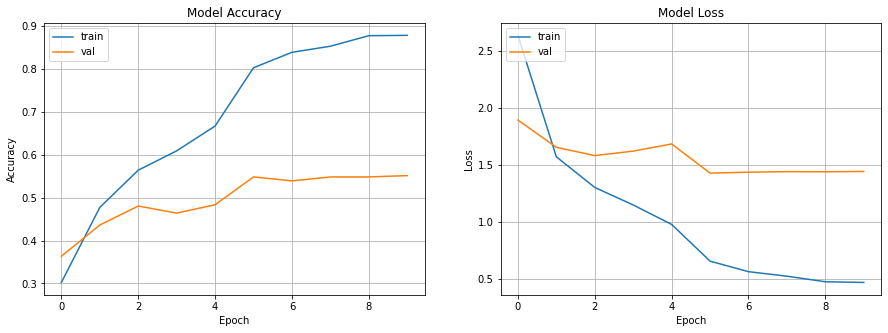

In [ ]:
def plot_history(history):

    fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

    # train and val accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'val'], loc='upper left')
    axs[0].grid(True)

    # train and val loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'val'], loc='upper left')
    axs[1].grid(True)
    
    fig.show()

plot_history(history)

In [ ]:
path_models = path + 'models/'
print(path_models)

model_1.save(path_models + 'brand-recognition-pre_vgg_16.h5')

/content/drive/MyDrive/Applied Deep Learning/brand-recognition/data/models/


### Evaluate the model on the test set

#### Load the model

In [ ]:
model_1 = load_model(path_models + 'brand-recognition-pre_vgg_16.h5')

OSError: ignored

#### Evaluate the model on the whole test set



In [ ]:
model_1.evaluate(test_generator, steps=len(test_generator))

In [ ]:
y_true = test_generator.classes
y_predicted = model_1.predict(test_generator).argmax(axis=1)

#### We check the accuracy of the model

In [ ]:
print(f'Accuracy: {(y_true == y_predicted).sum() / len(y_true):.4f}')

In [ ]:
matrix = confusion_matrix(y_true,
                          y_predicted)

matrix

In [ ]:
sns.heatmap(matrix, xticklabels=[class_to_brand[i] for i in range(10)], yticklabels=[class_to_brand[i] for i in range(10)], cmap='inferno_r', annot=True)

#### See images for which it did not work

In [ ]:
paths_miss_cl = np.array(test_generator.filepaths)[y_true != y_predicted]
true_miss_cl = y_true[y_true != y_predicted]
pred_miss_cl = y_predicted[y_true != y_predicted]

In [ ]:
def predict_img(path_img, model):
    
    img_test = load_img(path_img, target_size=(img_height, img_width))
    input_arr = img_to_array(img_test)
    input_arr = np.array([input_arr])
    input_arr -= [123.68, 116.779, 103.939]
    predictions = model.predict(input_arr).argmax()
    
    return img_test, predictions


In [ ]:
nb_miss = (y_true != y_predicted).sum()
nb_miss

In [ ]:
fig, axs = plt.subplots(nrows=20//3 + 1, ncols=3, figsize=(25, 50))

for idx, path_miss in enumerate(paths_miss_cl[:20]):
    i = idx // 3
    j = idx % 3
    img = load_img(path_miss)
    axs[i,j].imshow(img)
    axs[i,j].set_title(f'True class: {class_to_brand[true_miss_cl[idx]]} / Predicted class: {class_to_brand[pred_miss_cl[idx]]}')

fig.show()


## ResNet

In [ ]:
def build_model():

    model_resnet = ResNet50(
        include_top=False,
        weights='imagenet'
    )

    x = model_resnet.output

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_initializer='normal')(x)
    predictions = Dense(10, activation='softmax')(x)

    model = Model(inputs=model_resnet.input, outputs=predictions)

    for layer in model_resnet.layers:
        layer.trainable = False

    return model

model_2 = build_model()

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1, min_delta=1e-4)
checkpoint = ModelCheckpoint(path_models + 'resNet50-brand-recognition.hdf5', monitor='val_loss', verbose=1, mode='auto', save_freq='epoch', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_delta=1e-4)
history = model_2.fit(train_generator, epochs=20, batch_size=32, validation_data=val_generator, callbacks=[early_stop, checkpoint, reduce_lr])

Epoch 1/20
244/244 [==============================] - ETA: 0s - loss: 0.7508 - accuracy: 0.7465
Epoch 1: val_loss improved from inf to 1.36964, saving model to /content/drive/MyDrive/Applied Deep Learning/brand-recognition/data/models/resNet50-brand-recognition.hdf5
244/244 [==============================] - 2455s 10s/step - loss: 0.7508 - accuracy: 0.7465 - val_loss: 1.3696 - val_accuracy: 0.5617 - lr: 0.0010
Epoch 2/20
244/244 [==============================] - ETA: 0s - loss: 0.6622 - accuracy: 0.7814

In [ ]:
def plot_history(history):

    fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

    # train and val accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'val'], loc='upper left')
    axs[0].grid(True)

    # train and val loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'val'], loc='upper left')
    axs[1].grid(True)
    
    fig.show()

plot_history(history)

In [ ]:
model_2 = load_model('/content/drive/MyDrive/Applied Deep Learning/brand-recognition/data/models/resNet50-brand-recognition_recent.hdf5')

#### Evaluate the ResNet model on the whole test set


In [ ]:
model_2.evaluate(test_generator, steps=len(test_generator))

31/31 [==============================] - 283s 9s/step - loss: 1.4260 - accuracy: 0.5482


[1.4260419607162476, 0.5482233762741089]

In [ ]:
model_2.evaluate(test_generator, steps=len(test_generator))

31/31 [==============================] - 278s 9s/step - loss: 1.4213 - accuracy: 0.5543


[1.4213125705718994, 0.5543147325515747]

In [ ]:
y_true = test_generator.classes
y_resnet_predicted = model_2.predict(test_generator).argmax(axis=1)

#### We check the accuracy of the model

In [ ]:
print(f'Accuracy: {(y_true == y_resnet_predicted).sum() / len(y_true):.4f}')

Accuracy: 0.5543


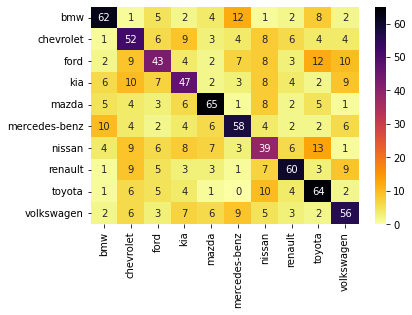

In [ ]:
matrix_resenet = confusion_matrix(y_true, y_resnet_predicted)

sns.heatmap(matrix_resenet, 
            xticklabels=[class_to_brand[i] for i in range(10)], 
            yticklabels=[class_to_brand[i] for i in range(10)], 
            cmap='inferno_r', 
            annot=True)

#### See images for which it did not work

In [ ]:
paths_miss_cl_resnet = np.array(test_generator.filepaths)[y_true != y_resnet_predicted]
true_miss_cl_resnet = y_true[y_true != y_resnet_predicted]
pred_miss_cl_resnet = y_resnet_predicted[y_true != y_resnet_predicted]

In [ ]:
nb_miss_resnet = (y_true != y_resnet_predicted).sum()
nb_miss_resnet

439

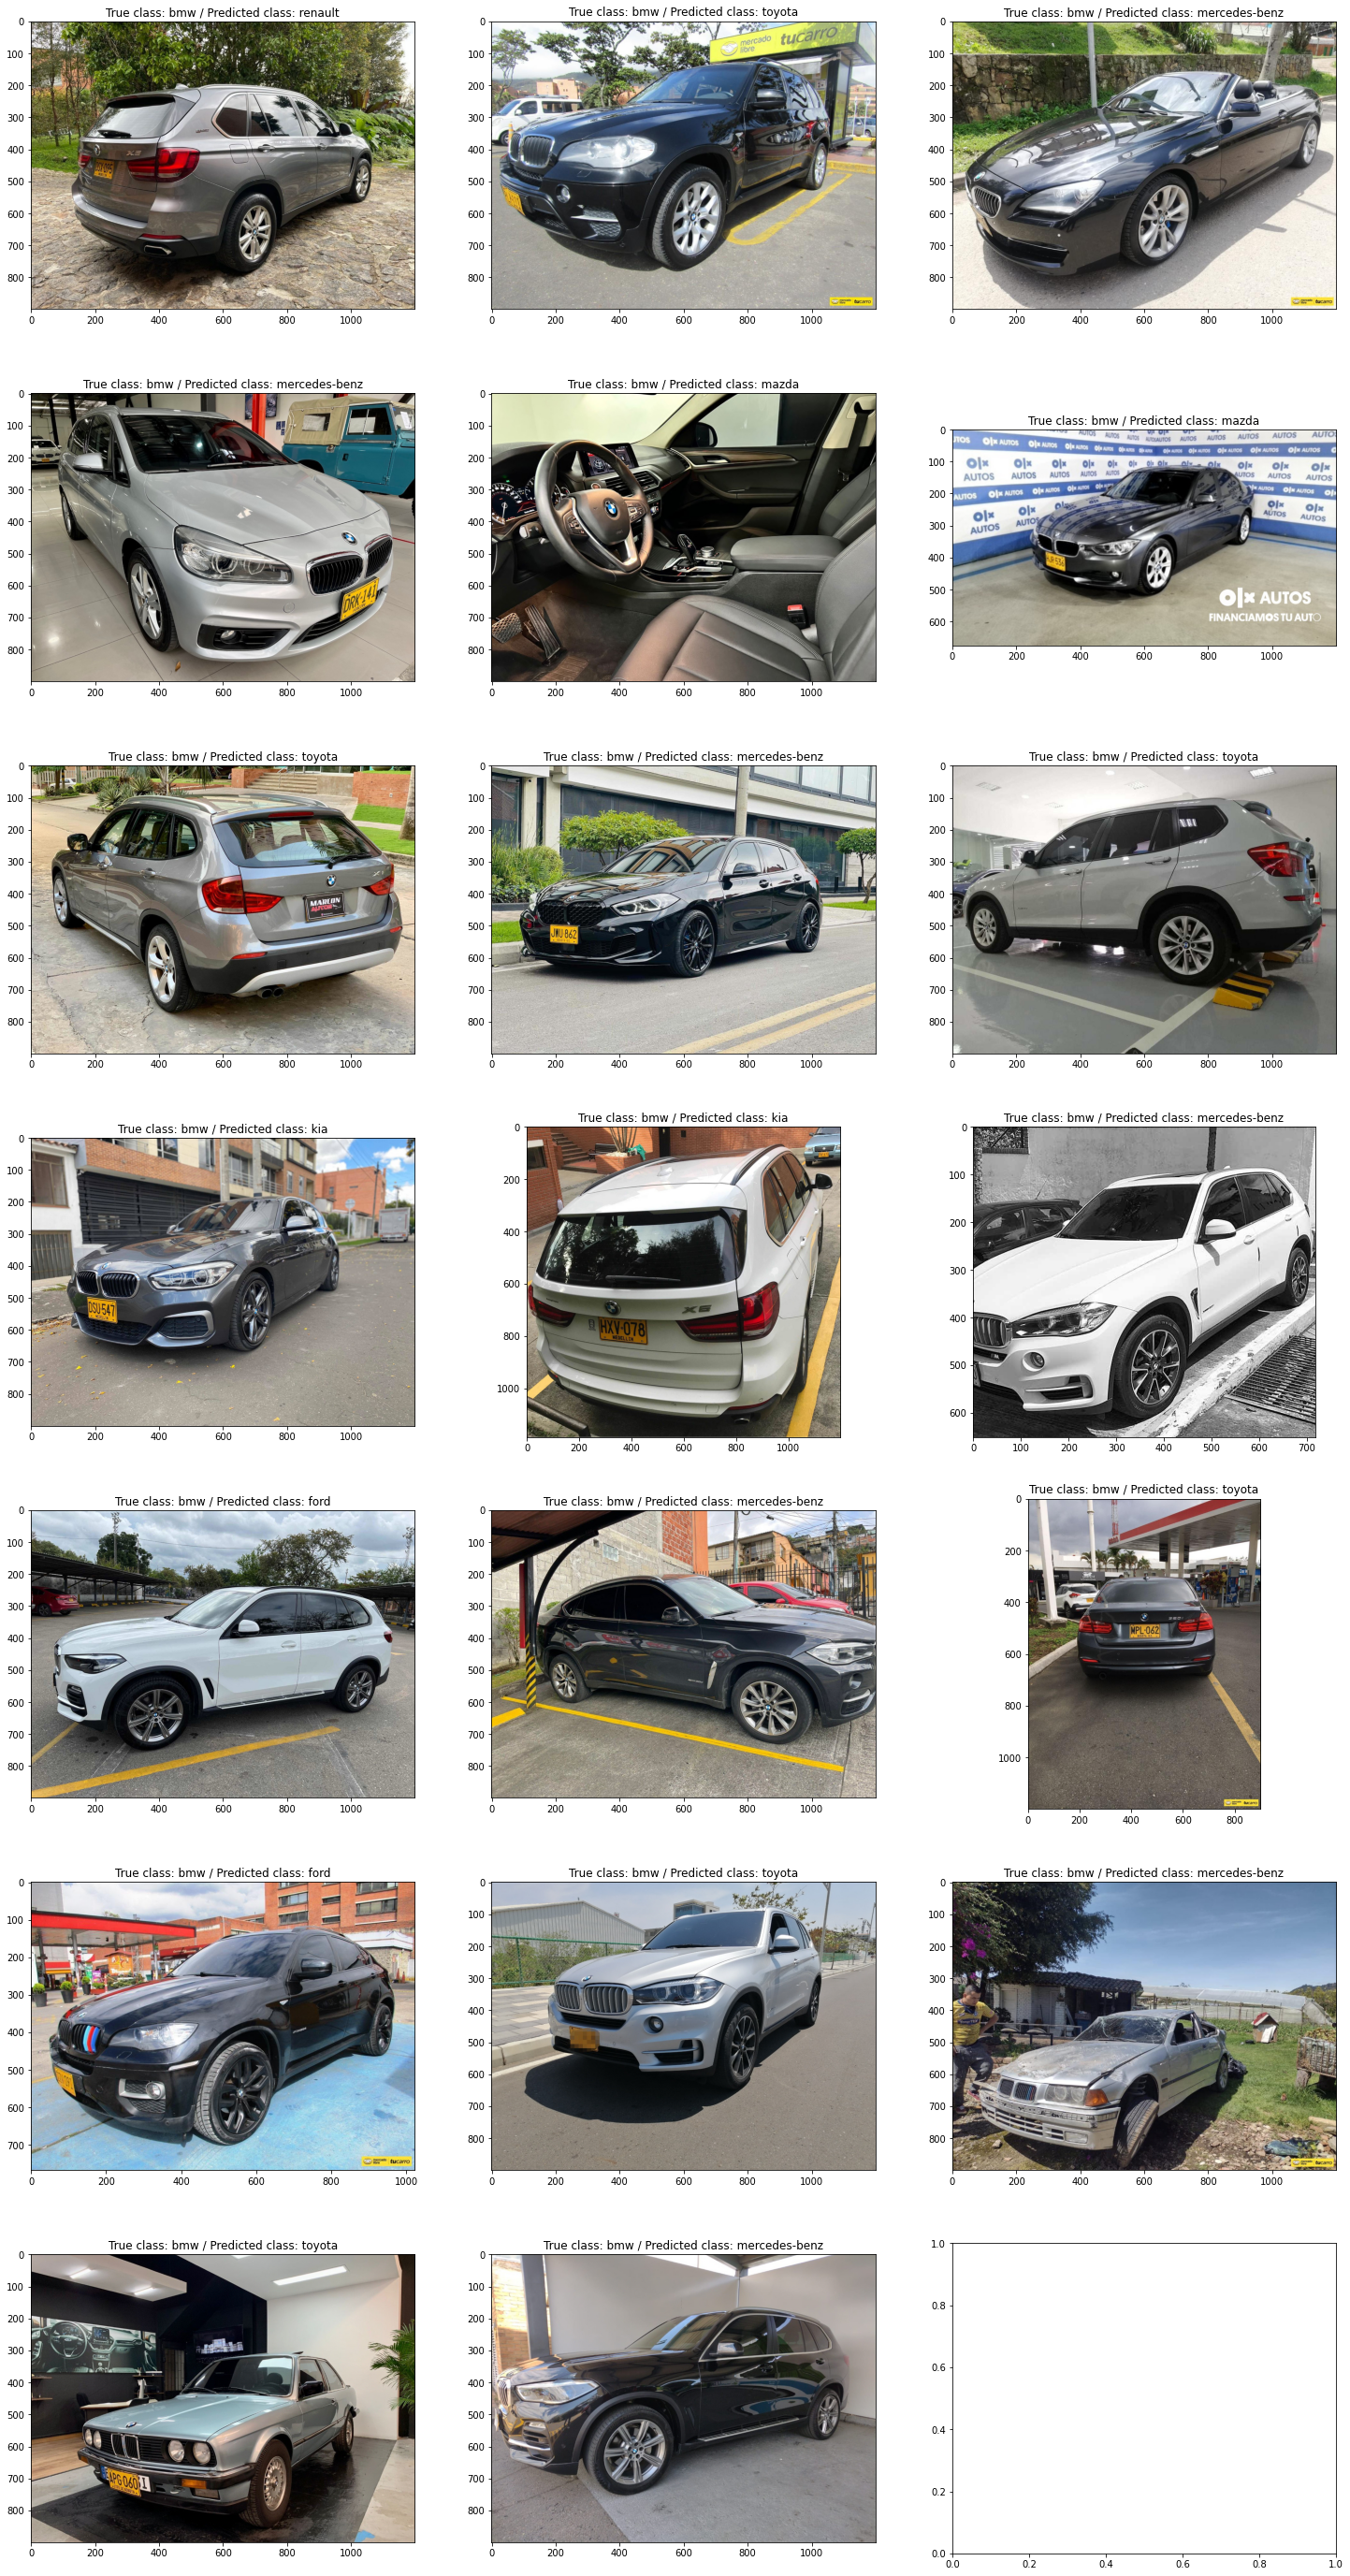

In [ ]:
fig, axs = plt.subplots(nrows=20//3 + 1, ncols=3, figsize=(25, 50))

for idx, path_miss in enumerate(paths_miss_cl_resnet[:20]):
    i = idx // 3
    j = idx % 3
    img = load_img(path_miss)
    axs[i,j].imshow(img)
    axs[i,j].set_title(f'True class: {class_to_brand[true_miss_cl_resnet[idx]]} / Predicted class: {class_to_brand[pred_miss_cl_resnet[idx]]}')

fig.show()